# Classify using convolutional neural network (CNN)

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, LeakyReLU, Flatten
from tensorflow.keras import activations
from tensorflow.keras import initializers
from sklearn.preprocessing import StandardScaler

import numpy as np
from os.path import join
from sklearn.model_selection import train_test_split

2025-01-14 14:21:23.397664: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 14:21:23.540528: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736860883.600565    6173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736860883.626683    6173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 14:21:23.765566: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
input_width = 300
input_height = 300
input_depth = 3
input_dim = input_width*input_height*input_depth
input_shape = (input_width, input_height, input_depth)
output_classes = 7

In [11]:
# 5000 samples in training set: 18.95% accuracy on test set
# 100 samples in training set: 15.93% accuracy on test set
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(output_classes, activation='softmax'))

/home/atroncos/workspace/oa_venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
#model = Sequential()
#model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
#model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
#model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
#model.add(Flatten())
#model.add(Dense(64, activation='relu'))
#model.add(Dense(output_classes, activation='softmax'))

In [13]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

# Define loss function, optimizer, and metrics to track during training
model.compile(
    optimizer='adam', # .. or optimizers.SGD(lr=0.01)
    loss='sparse_categorical_crossentropy', # .. or losses.sparse_categorical_crossentropy
    metrics=['acc'] # .. or metrics.sparse_categorical_accuracy
)


In [14]:
DATA_PATH = 'data'

with np.load(join(DATA_PATH, 'processed_data.npz')) as data:
    data_dict=dict(data.items())
X = data_dict['X']
y = data_dict['y']

In [15]:
# Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)
print('The training dataset has {} entries, the test dataset {}.'.format(
    len(X_train), len(X_test)))

The training dataset has 11522 entries, the test dataset 3841.


In [27]:
import random

# Get a smaller random sample 
NUM_SAMPLES = 10000
idx = random.sample(range(len(X_train)-1), NUM_SAMPLES)
X_train_rnd = X_train[idx]
y_train_rnd = y_train[idx]

In [28]:
scale = False

if scale:
    # Rescale train and validation data
    scaler = StandardScaler()
    X_train_preprocessed = scaler.fit_transform(X_train_rnd.reshape([-1, input_dim])).reshape([-1, input_width, input_height, input_depth])
    X_test_preprocessed = scaler.transform(X_test.reshape([-1,input_dim])).reshape([-1, input_width, input_height, input_depth])
else:
    X_train_preprocessed = X_train_rnd
    X_test_preprocessed = X_test

classes, y_train_preprocessed = np.unique(y_train_rnd, return_inverse=True)
_, y_test_preprocessed = np.unique(y_test, return_inverse=True)

print('Train:', X_train_preprocessed.shape)
print('Test:', X_test_preprocessed.shape)

Train: (10000, 300, 300, 3)
Test: (3841, 300, 300, 3)


Display some images as a check

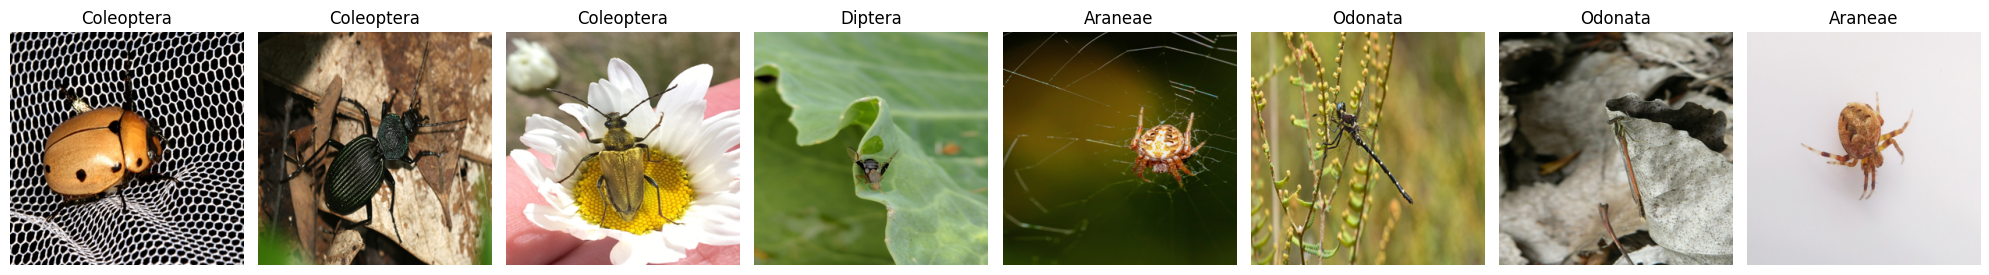

In [29]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

check_images = 8
idx = random.sample(range(len(X_train_preprocessed)-1), check_images)
fig, ax = plt.subplots(1, check_images, figsize=(20, 10))
for i, id in enumerate(idx):
    data = X_train_preprocessed[id].astype('uint8')
    img = Image.fromarray(data, 'RGB')
    ax[i].imshow(img)
    ax[i].set_title(classes[y_train_preprocessed[id]])
    ax[i].axis('off')
plt.tight_layout()
plt.show();

In [30]:
%%time
# Fit model
history = model.fit(
    x=X_train_preprocessed, y=y_train_preprocessed,
    validation_split=0.2, batch_size=32, epochs=10,
    shuffle=True # Shuffle training samples
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - acc: 0.1640 - loss: 7.2623 - val_acc: 0.1650 - val_loss: 1.9893
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 629s 3s/step - acc: 0.5057 - loss: 1.5439 - val_acc: 0.1820 - val_loss: 2.1896
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - acc: 0.7024 - loss: 1.0149 - val_acc: 0.1820 - val_loss: 2.5927
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 618s 2s/step - acc: 0.8472 - loss: 0.5913 - val_acc: 0.1820 - val_loss: 2.5437
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 621s 2s/step - acc: 0.8882 - loss: 0.4090 - val_acc: 0.1770 - val_loss: 3.3756
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - acc: 0.9310 - loss: 0.3107 - val_acc: 0.1740 - val_loss: 3.5935
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 625s 3s/step - acc: 0.9381 - loss: 0.2533 - val_acc: 0.1905 - val_loss: 3.3812
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 616s 2s/step - acc: 0.9496 - loss: 0.2645 - val_acc: 0.1745 - val_loss: 3.1870
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 617s 2s/

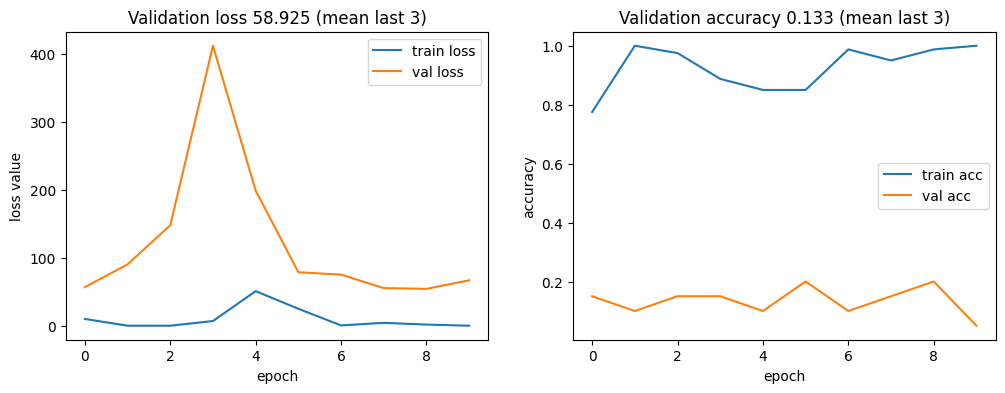

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history['loss'], label='train loss')
ax1.plot(history.history['val_loss'], label='val loss')
ax1.set_title('Validation loss {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_loss'][-3:]) # last three values
))
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss value')
ax1.legend()

# Plot accuracy values
ax2.plot(history.history['acc'], label='train acc')
ax2.plot(history.history['val_acc'], label='val acc')
ax2.set_title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(history.history['val_acc'][-3:]) # last three values
))
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
plt.show()


In [26]:
(test_loss, test_accuracy) = model.evaluate(X_test_preprocessed, y_test_preprocessed, batch_size=32)

print('Test loss: {:.2f}'.format(test_loss)) 
print('Test accuracy: {:.2f}%'.format(100*test_accuracy)) 


121/121 ━━━━━━━━━━━━━━━━━━━━ 65s 543ms/step - acc: 0.1496 - loss: 66.1510
Test loss: 69.70
Test accuracy: 15.10%
